# No.7 Convolutional Neural Network (Handwriting Recognizer)

Download the trained model binary.

In [1]:
!curl -OL https://storage.googleapis.com/onboard/cnn_session-20000

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37.4M  100 37.4M    0     0  28.4M      0  0:00:01  0:00:01 --:--:-- 28.5M


Import modules.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

Define the first convolutional filter and pooling layer.

In [3]:
num_filters1 = 32

x = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(x, [-1,28,28,1])

W_conv1 = tf.Variable(tf.truncated_normal([5,5,1,num_filters1],
                                          stddev=0.1))
h_conv1 = tf.nn.conv2d(x_image, W_conv1,
                       strides=[1,1,1,1], padding='SAME')

b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))
h_conv1_cutoff = tf.nn.relu(h_conv1 + b_conv1)

h_pool1 =tf.nn.max_pool(h_conv1_cutoff, ksize=[1,2,2,1],
                        strides=[1,2,2,1], padding='SAME')

Define the second convolutional filter and pooling layer.

In [4]:
num_filters2 = 64

W_conv2 = tf.Variable(
            tf.truncated_normal([5,5,num_filters1,num_filters2],
                                stddev=0.1))
h_conv2 = tf.nn.conv2d(h_pool1, W_conv2,
                       strides=[1,1,1,1], padding='SAME')

b_conv2 = tf.Variable(tf.constant(0.1, shape=[num_filters2]))
h_conv2_cutoff = tf.nn.relu(h_conv2 + b_conv2)

h_pool2 =tf.nn.max_pool(h_conv2_cutoff, ksize=[1,2,2,1],
                        strides=[1,2,2,1], padding='SAME')

Define a fully-connected layer and a softmax function.

In [5]:
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*num_filters2])

num_units1 = 7*7*num_filters2
num_units2 = 1024

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.constant(0.1, shape=[num_units2]))
hidden2 = tf.nn.relu(tf.matmul(h_pool2_flat, w2) + b2)

keep_prob = tf.placeholder(tf.float32)
hidden2_drop = tf.nn.dropout(hidden2, keep_prob)

w0 = tf.Variable(tf.zeros([num_units2, 10]))
b0 = tf.Variable(tf.zeros([10]))
p = tf.nn.softmax(tf.matmul(hidden2_drop, w0) + b0)

Preapare a session and initialize Variables. Then restore the saved session.

In [6]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(sess, './cnn_session-20000')

Prepare an JavaScript code for a white board area.

In [7]:
input_form = """
<table>
<td style="border-style: none;">
<div style="border: solid 2px #666; width: 143px; height: 144px;">
<canvas width="140" height="140"></canvas>
</div></td>
<td style="border-style: none;">
<button onclick="clear_value()">Clear</button>
</td>
</table>
"""

javascript = """
<script type="text/Javascript">
    var pixels = [];
    for (var i = 0; i < 28*28; i++) pixels[i] = 0
    var click = 0;

    var canvas = document.querySelector("canvas");
    canvas.addEventListener("mousemove", function(e){
        if (e.buttons == 1) {
            click = 1;
            canvas.getContext("2d").fillStyle = "rgb(0,0,0)";
            canvas.getContext("2d").fillRect(e.offsetX, e.offsetY, 8, 8);
            x = Math.floor(e.offsetY * 0.2)
            y = Math.floor(e.offsetX * 0.2) + 1
            for (var dy = 0; dy < 2; dy++){
                for (var dx = 0; dx < 2; dx++){
                    if ((x + dx < 28) && (y + dy < 28)){
                        pixels[(y+dy)+(x+dx)*28] = 1
                    }
                }
            }
        } else {
            if (click == 1) set_value()
            click = 0;
        }
    });
    
    function set_value(){
        var result = ""
        for (var i = 0; i < 28*28; i++) result += pixels[i] + ","
        var kernel = IPython.notebook.kernel;
        kernel.execute("image = [" + result + "]");
    }
    
    function clear_value(){
        canvas.getContext("2d").fillStyle = "rgb(255,255,255)";
        canvas.getContext("2d").fillRect(0, 0, 140, 140);
        for (var i = 0; i < 28*28; i++) pixels[i] = 0
    }
</script>
"""

Execute the JavaScript and let a user to handwrite a character. The result is stored in a varibale 'image'.

In [8]:
from IPython.display import HTML
HTML(input_form + javascript)

Predict the probabilites for numbers 0,1,...,9

<Container object of 10 artists>

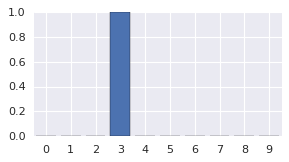

In [9]:
p_val = sess.run(p, feed_dict={x:[image], keep_prob:1.0})

fig = plt.figure(figsize=(4,2))
pred = p_val[0]
subplot = fig.add_subplot(1,1,1)
subplot.set_xticks(range(10))
subplot.set_xlim(-0.5,9.5)
subplot.set_ylim(0,1)
subplot.bar(range(10), pred, align='center')

Show filtered images from the first layer.

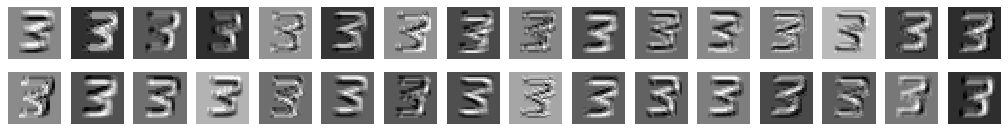

In [10]:
conv1_vals = sess.run(h_conv1, feed_dict={x:[image], keep_prob:1.0})

fig = plt.figure(figsize=(16,4))

for f in range(num_filters1):
    subplot = fig.add_subplot(4, 16, f+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv1_vals[0,:,:,f],
                   cmap=plt.cm.gray_r, interpolation='nearest') 

Show filtered images from the second layer.

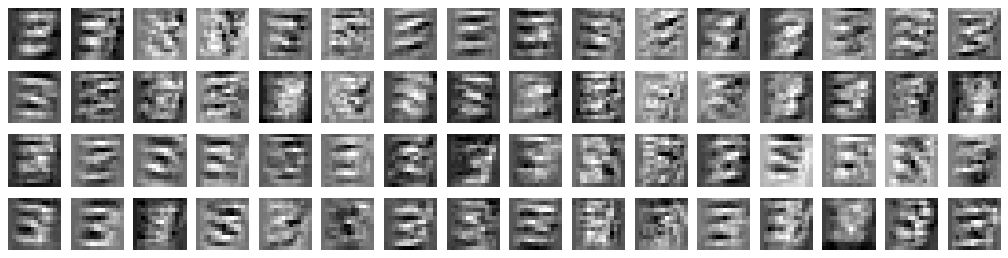

In [11]:
conv2_vals = sess.run(h_conv2, feed_dict={x:[image], keep_prob:1.0})

fig = plt.figure(figsize=(16,8))

for f in range(num_filters2):
    subplot = fig.add_subplot(8, 16, f+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv2_vals[0,:,:,f],
                   cmap=plt.cm.gray_r, interpolation='nearest') 

Show final images used for the prediction.

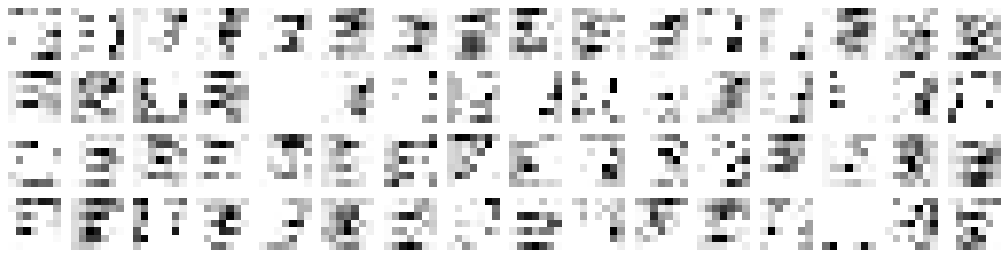

In [12]:
h_pool2 = sess.run(h_pool2, feed_dict={x:[image], keep_prob:1.0})

fig = plt.figure(figsize=(16,8))

for f in range(num_filters2):
    subplot = fig.add_subplot(8, 16, f+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(h_pool2[0,:,:,f],
                   cmap=plt.cm.gray_r, interpolation='nearest') 